In [ ]:
Написать модель Random Forest на датасет больных сердечными болезнями
Определить, какой атрибут оказывает наибольшее влияние на наличие или отсутствие болезни. 
Выдвинуть и оценить гипотезу на самый важный атрибут, 
полученный из feature_importance (Random_Forest). 
Сделать выводы

In [101]:
import pandas as pd
import pandas_profiling 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import scipy.stats as sts
import statistics

import researchpy as rp

%matplotlib inline

In [102]:
url = "http://yustiks.ru/dataset/cardio_train.csv"
data = pd.read_csv(url,sep=";")
data.isnull().any()
data.describe().round(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,49972.42,19468.87,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,28851.30,2467.25,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,0.00,10798.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,25006.75,17664.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,50001.50,19703.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,74889.25,21327.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,99999.00,23713.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


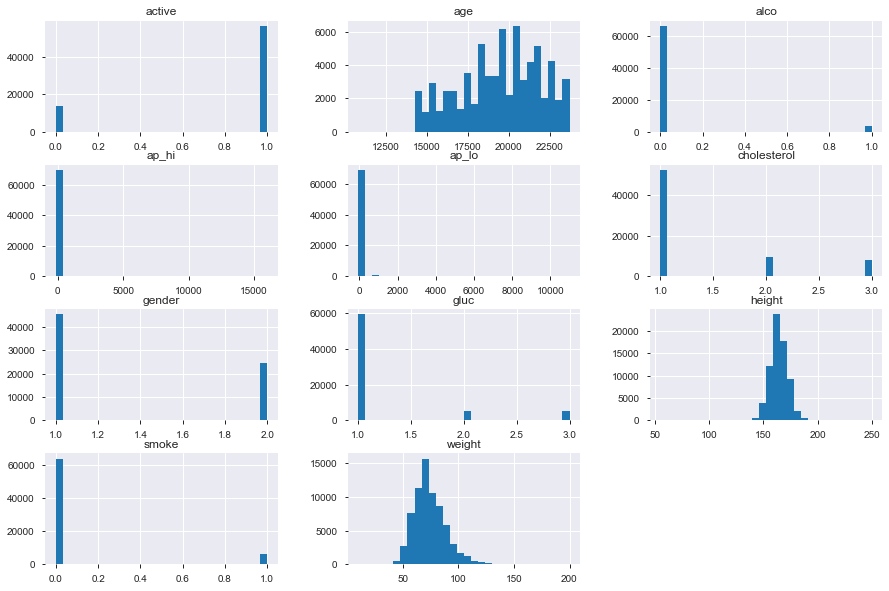

In [103]:
data.iloc[:,1:12].hist(figsize=(15,10), bins=30)
plt.show()

In [104]:
# отбрасываем записи с заведомо недостоверными данными / по артериальному давлению
ds= data[(data['ap_hi'] > 0)&
         (data['ap_hi'] < 320)&
         (data['ap_lo'] > 0)&        
         (data['ap_lo'] < 250)].iloc[:,1:]
print('Отбросили ', len(data) - len(ds), 'наблюдений, что составило', 
      round(100* (len(data) - len(ds)) / len(data) ,2), '% выборки') 
# приводим поле Возраст в читаемый вид / общеупотребимый формат
ds['age'] = ds['age'] / 365.25
ds.tail()

Отбросили  1015 наблюдений, что составило 1.45 % выборки


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,52.676249,2,168,76.0,120,80,1,1,1,0,1,0
69996,61.878166,1,158,126.0,140,90,2,2,0,0,1,1
69997,52.199863,2,183,105.0,180,90,3,1,0,1,0,1
69998,61.412731,1,163,72.0,135,80,1,2,0,0,0,1
69999,56.235455,1,170,72.0,120,80,2,1,0,0,1,0


In [105]:
# визуализация и анализ датасета после корректировок
pandas_profiling.ProfileReport(ds)

C:\Users\admin\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,13
Number of observations,68985
Total Missing (%),0.0%
Total size in memory,6.8 MiB
Average record size in memory,104.0 B
Numeric,8
Categorical,0
Boolean,5
Date,0
Text (Unique),0
Rejected,0


In [106]:
# создаем модель - Деревья решений  - на тестовой выборке
output_y = ds.cardio
input_x  = ds.iloc[:,:11]

x_train, x_test, y_train, y_test = train_test_split(input_x, output_y, test_size = 0.2, random_state = 42)

# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)

# classification report:
model_pred = model.predict(x_test)
print(classification_report(y_test, model_pred))
model.score(x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6925
           1       0.72      0.69      0.71      6872

    accuracy                           0.71     13797
   macro avg       0.71      0.71      0.71     13797
weighted avg       0.71      0.71      0.71     13797



0.7130535623686308

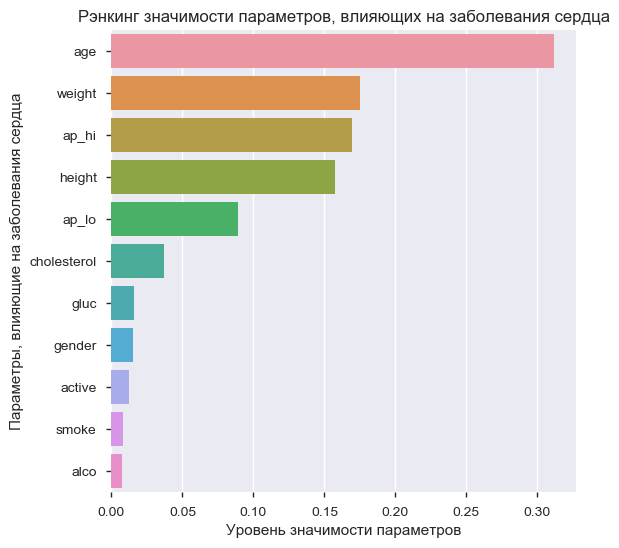

In [114]:
# формируем рэнкинг параметров по уровню значимости влияния на сердечные болезни

headers = list(input_x.columns.values)
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Уровень значимости параметров')
plt.ylabel('Параметры, влияющие на заболевания сердца')
plt.title("Рэнкинг значимости параметров, влияющих на заболевания сердца")
plt.show()

In [108]:
# Детализация анализа влияния возраста на заболевания сердца по возрастным группам
age1 = ds[ds ['age']<=40]['cardio']
age2 = ds[(ds['age']>40) & (ds['age']<=60)]['cardio']
age3 = ds[ds ['age']>60]['cardio']

sts.f_oneway(age1, age2, age3)
print('p value = ', sts.f_oneway(age1, age2, age3)[1].round(5), ', отвергаем нулевую гипотезу.')

# Множественный тест ANOVA свидетельствует о значительном  стат различии уровня 
# заболеваемости  по возрастным группам

p value =  0.0 , отвергаем нулевую гипотезу.


In [109]:
# сравним две возрастные группы (младше 40 лет и старше 60 лет) по уровню сердечных заболеваний
descriptives, results = rp.ttest(age1, age3)
print(descriptives)
print('_____________________________')
print(results)
# очевидные статистические различия кратные различия уровня средних по группам

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   1880.0  0.235638  0.424510  0.009791   0.216437  0.254840
1    cardio  12548.0  0.667517  0.471122  0.004206   0.659273  0.675761
2  combined  14428.0  0.611242  0.487485  0.004058   0.603287  0.619197
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.4319
1            Degrees of freedom =   14426.0000
2                             t =     -37.5299
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.9281
7                     Hedge's g =      -0.9281
8                 Glass's delta =      -1.0174
9                             r =       0.2982


In [110]:
# Добавим в состав анализа индекс массы тела 
# и определим группу пациентов с очевидным ожирением (индекс > 40)

ds['weight_index'] = ds['weight'] / (ds['height']/100)**2
ds2 = ds[ds['weight_index']>40]

age1_ow = ds2[ds2 ['age']<=60]['cardio']
age2_ow = ds2[(ds2['age']>40) & (ds2['age']<=60)]['cardio']
age3_ow = ds2[ds2 ['age']>60]['cardio']
print('p value = ', sts.f_oneway(age1_ow, age2_ow, age3_ow)[1].round(5))

# Для пациентов с очевидным ожирением риск сердечных заболеваний уже частично реализован
# в рамках фактора ожирение / статистические различия заболеваемости по возрасту менее значимы

p value =  0.07949


In [111]:
# Определим группу пациентов с повышенным артериальным давлением (ap_i > 140)

ds3 = ds[ds['ap_hi']>140]

age1_ah = ds3[ds3 ['age']<=60]['cardio']
age2_ah = ds3[(ds3['age']>40) & (ds3['age']<=60)]['cardio']
age3_ah = ds3[ds3 ['age']>60]['cardio']
print('p value = ', sts.f_oneway(age1_ah, age2_ah, age3_ah)[1].round(5))


p value =  0.96723


In [112]:
descriptives, results = rp.ttest(age1_ah, age3_ah)
print(descriptives)
print('_____________________________')
print(results)

   Variable       N      Mean        SD        SE  95% Conf.  Interval
0    cardio  6794.0  0.858699  0.348358  0.004226   0.850414  0.866984
1    cardio  2364.0  0.856599  0.350555  0.007210   0.842460  0.870737
2  combined  9158.0  0.858157  0.348908  0.003646   0.851010  0.865304
_____________________________
                Independent t-test    results
0  Difference (cardio - cardio) =      0.0021
1            Degrees of freedom =   9156.0000
2                             t =      0.2520
3         Two side test p value =      0.8010
4        Difference < 0 p value =      0.5995
5        Difference > 0 p value =      0.4005
6                     Cohen's d =      0.0060
7                     Hedge's g =      0.0060
8                 Glass's delta =      0.0060
9                             r =      0.0026


In [113]:
# Для группы пациентов с повышенным артериальным давлением 
# статистические различия заболеваемости по возрасту практически отсутствуют